In [1]:
import hisepy
import os
import pandas as pd
import scanpy as sc

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
def read_parquet_uuid(pq_uuid):
    pq_path = '/home/jupyter/cache/{u}'.format(u = pq_uuid)
    if not os.path.isdir(pq_path):
        hise_res = hisepy.reader.cache_files([pq_uuid])
    pq_filename = os.listdir(pq_path)[0]
    pq_file = '{p}/{f}'.format(p = pq_path, f = pq_filename)
    df = pd.read_parquet(pq_file)
    return df

## Read subclustering and barcode annotations from HISE

In [4]:
cell_class = 't-cells'

In [5]:
h5ad_uuid = 'd6ebc576-34ea-4394-a569-e35e16f20253'

In [6]:
adata = read_adata_uuid(h5ad_uuid)

In [7]:
anno_uuid = '75cb6602-0179-4128-9171-83c269a2b340'

In [8]:
anno = read_parquet_uuid(anno_uuid)

In [9]:
anno.head()

,barcodes,AIFI_L1,AIFI_L2,AIFI_L3
0,cf71f47048b611ea8957bafe6d70929e,T cell,MAIT,CD8 MAIT
1,cf71f54248b611ea8957bafe6d70929e,T cell,Naive CD4 T cell,Core naive CD4 T cell
2,cf71fb7848b611ea8957bafe6d70929e,T cell,Memory CD4 T cell,CM CD4 T cell
3,cf7216a848b611ea8957bafe6d70929e,T cell,Memory CD4 T cell,GZMB- CD27+ EM CD4 T cell
4,cf72178448b611ea8957bafe6d70929e,T cell,Naive CD4 T cell,SOX4+ naive CD4 T cell


## Add annotations to barcodes

In [10]:
obs = adata.obs
obs = obs.reset_index(drop = True)
obs = obs.merge(anno, on = 'barcodes', how = 'left')
obs = obs.set_index('barcodes', drop = False)

In [11]:
adata.obs = obs

## Drop doublet/contamination labels

In [12]:
exclude_terms = [
    'Contamination', 'contamination',
    'Doublet', 'doublet',
    'Mito', 'mito'
]

In [13]:
all_types = adata.obs['AIFI_L3'].unique().tolist()

In [14]:
exclude_types = []
for cell_type in all_types:
    for term in exclude_terms:
        if term in cell_type:
            exclude_types.append(cell_type)

In [15]:
exclude_types

['Contamination',
 'Naive CD8 T cell Platelet Doublets',
 'C5_C12_Contamination',
 'Proliferating Cells+Monocytes Doublets',
 'CD4 naive Platelet Doublets',
 'CD4 naive CD16 Monocytes Doublets']

In [16]:
keep_types = []
for cell_type in all_types:
    if not cell_type in exclude_types:
        keep_types.append(cell_type)

In [17]:
adata = adata[adata.obs['AIFI_L3'].isin(keep_types)]
adata.shape

(1157700, 1487)

## Plot L2 marker expression

In [18]:
l2_markers = [
    'CD3E', 'CD4', 'CD8A', 'TRAC', 'TRDC', 
    'LEF1', 'TCF7', 'CCR7', 'SELL', 'ITGB1', 
    'FAS', 'CD27', 'CD28', 'FOXP3', 'RTKN2', 
    'IKZF2', 'ZNF683', 'NKG7', 'KLRC2', 'KLRF1', 
    'KLRB1', 'KLRD1', 'GZMA', 'GZMK', 'GZMB', 
    'PRF1', 'GNLY', 'IFI44L', 'IRF7', 'MKI67', 
    'TRDV1', 'TRDV2', 'TRDV3', 'MME', 'SOX4'
]

Set L2 category order

In [19]:
category_order = [
    'Naive CD4 T cell',
    'Naive CD8 T cell',
    'DN T cell',
    'Memory CD4 T cell',
    'Treg',
    'Proliferating T cell',
    'MAIT',
    'CD8aa',
    'Memory CD8 T cell',
    'gdT'
]

adata.obs['AIFI_L2'] = (
    adata.obs['AIFI_L2']
    .cat
    .set_categories(category_order, ordered=True)
)

/tmp/ipykernel_4263/4156893413.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['AIFI_L2'] = (


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


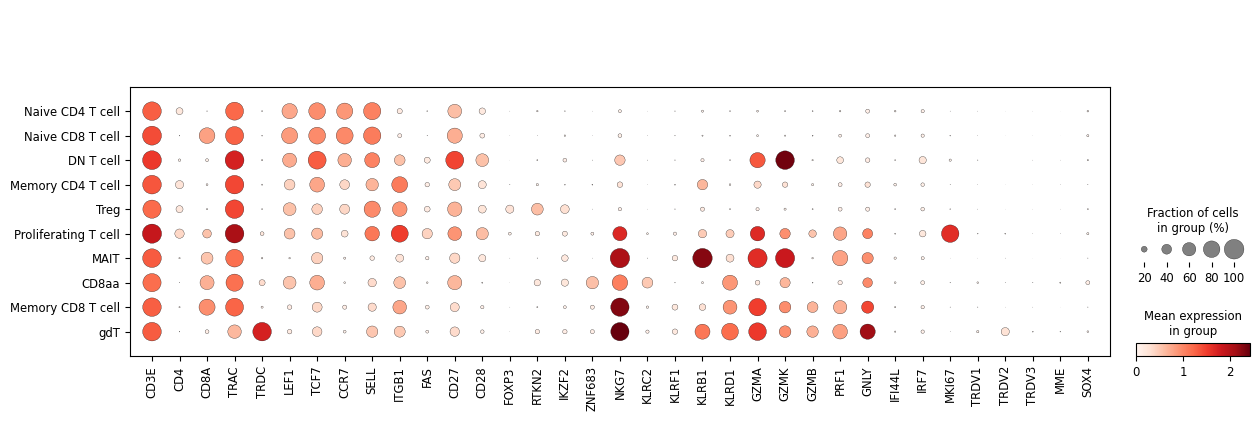

In [20]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L2',
    var_names = l2_markers,
    log = True
)

## Plot L3 marker expression

In [32]:
l3_markers = [
    'CD27', 'CD28', 'KLRF1', 'KLRB1', 'KLRD1', 
    'KLRC1', 'KLRC2', 'GZMA', 'GZMB', 'GZMK', 
    'GZMH', 'PRF1', 'CCL5', 'GNLY', 'GATA3', 
    'TBX21', 'EOMES', 'LEF1', 'TCF7', 'IKZF2',
    'SOX4', 'IFI44L'
]

Set L3 category order

In [29]:
category_order = [
    'Naive CD4 Treg',
    'Core naive CD8 T cell',
    'SOX4+ naive CD8 T cell',
    'Core naive CD4 T cell',
    'SOX4+ naive CD4 T cell',
    'CM CD4 T cell',
    'GZMB- CD27- EM CD4 T cell',
    'ISG+ memory CD4 T cell',
    'ISG+ memory CD8 T cell',
    'ISG+ naive CD4 T cell',
    'ISG+ naive CD8 T cell',
    'Proliferating T cell',
    'DN T cell',
    'KLRB1+ memory CD8 Treg',
    'GZMK+ memory CD4 Treg',
    'KLRB1+ memory CD4 Treg',
    'Memory CD4 Treg',
    'Memory CD8 Treg',
    'KLRF1- GZMB+ CD27- EM CD8 T cell',
    'KLRF1- GZMB+ CD27- memory CD4 T cell',
    'KLRF1- effector Vd1 gdT',
    'KLRF1+ GZMB+ CD27- EM CD8 T cell',
    'KLRF1+ effector Vd1 gdT',
    'GZMK+ CD27+ EM CD8 T cell',
    'GZMB+ Vd2 gdT',
    'GZMK+ Vd2 gdT',
    'CD8aa',
    'Naive Vd1 gdT',
    'SOX4+ Vd1 gdT',
    'ISG+ MAIT',
    'CD4 MAIT',
    'CD8 MAIT',
    'GZMB- CD27+ EM CD4 T cell',
    'CM CD8 T cell',
    'GZMK- CD27+ EM CD8 T cell'
]

In [30]:
adata.obs['AIFI_L3'] = (
    adata.obs['AIFI_L3']
    .cat
    .set_categories(category_order, ordered=True)
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


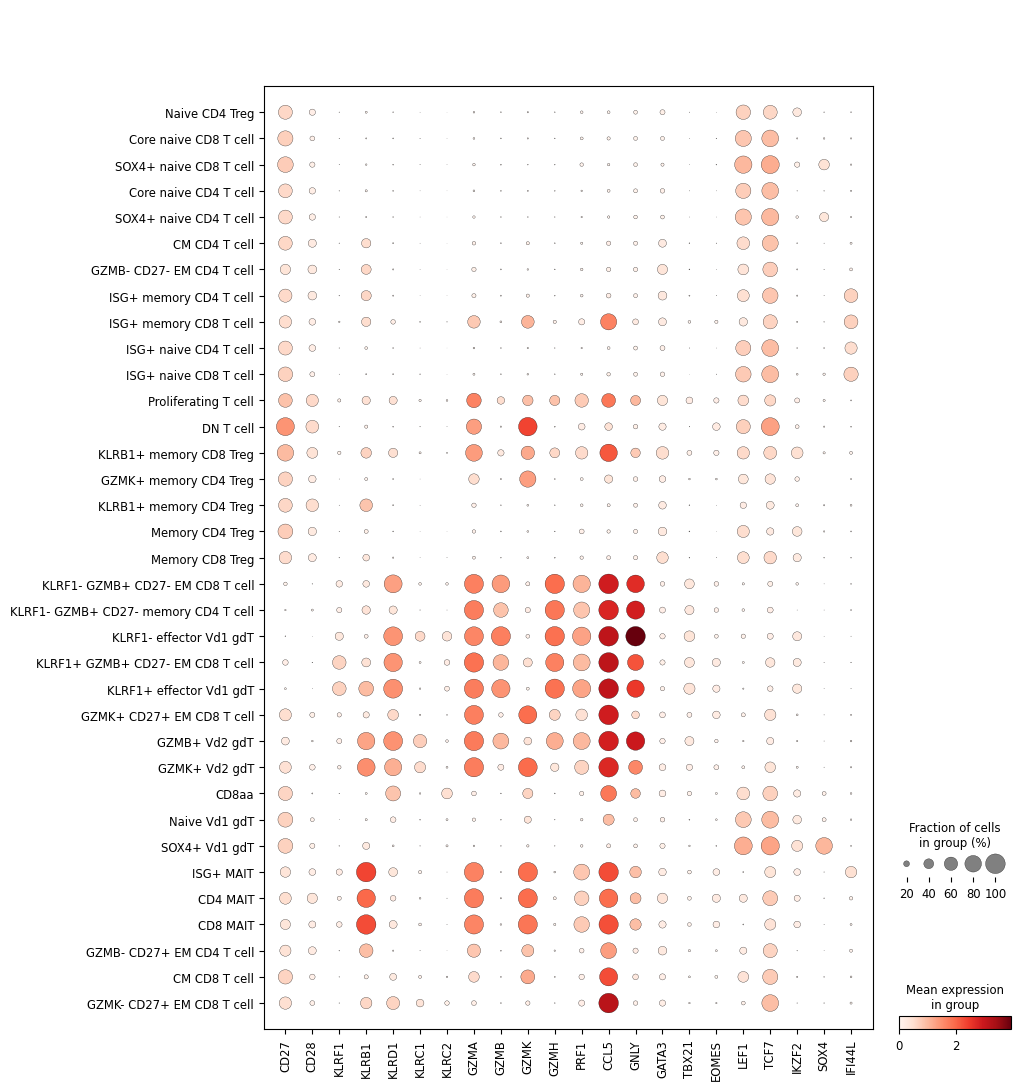

In [33]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L3',
    var_names = l3_markers,
    log = True
)

In [24]:
import session_info
session_info.show()